# 05.3 Regression for Non-Random Data

**Chapter**: 5 - The Unreasonable Effectiveness of Linear Regression  
**Section**: 3 - Regression For Non-Random Data  
**Facure Source**: 05-The-Unreasonable-Effectiveness-of-Linear-Regression.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Problem with Observational Data](#11-the-problem-with-observational-data)
   - 1.2 [Controls as Conditional Randomization](#12-controls-as-conditional-randomization)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Conditional Ignorability](#21-conditional-ignorability)
   - 2.2 [Why Adding Controls Helps](#22-why-adding-controls-helps)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [The Wage-Education Example](#31-the-wage-education-example)
   - 3.2 [Bias Reduction with Controls](#32-bias-reduction-with-controls)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    compare_coefficients,
    create_tufte_figure,
    TUFTE_PALETTE,
)
import statsmodels.formula.api as smf

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Most real-world causal questions involve observational data. Interviewers test whether you understand *when* regression works and *why* controls help.

### 1.1 The Problem with Observational Data

As Facure emphasizes, randomized experiments are the gold standard but often infeasible:

- You can't randomly assign years of education
- You can't randomly assign McKinsey consultants to firms
- Ethical and practical constraints abound

With observational data, **selection bias** creeps in. People who get more education:
- May have higher IQ
- Likely have wealthier parents
- May be more ambitious

These factors affect wages *independently* of education itself.

### 1.2 Controls as Conditional Randomization

Facure's insight: **regression with controls creates a form of conditional randomization**.

Recall from Section 02 (FWL Theorem):

$$\hat{\kappa} = \frac{\text{Cov}(Y, \tilde{T})}{\text{Var}(\tilde{T})}$$

where $\tilde{T}$ are residuals from regressing $T$ on controls $X$.

**Key insight**: $\tilde{T}$ is the part of treatment that *cannot be predicted* by the controls. If we've controlled for all confounders, this residual variation is "as good as random."

★ Insight ─────────────────────────────────────
- Controls "partial out" confounding variation
- The coefficient reflects treatment effect *holding controls fixed*
- This works only if all confounders are observed and included
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Conditional Ignorability

**Assumption (Conditional Ignorability / Selection on Observables)**:

$$(Y_0, Y_1) \perp T \mid X$$

Given covariates $X$, treatment assignment is independent of potential outcomes.

**Interpretation**: Within strata defined by $X$, treatment is "as good as random."

**Alternative formulation (Mean Independence)**:

$$E[Y_0 | T, X] = E[Y_0 | X]$$

The expected potential outcome under control doesn't depend on treatment, once we condition on $X$.

### 2.2 Why Adding Controls Helps

Consider the linear model:

$$Y_i = \beta_0 + \kappa T_i + X_i'\gamma + u_i$$

**Proposition**: Under conditional ignorability, if the outcome model is correctly specified, $\hat{\kappa}$ is consistent for the ATE.

**Proof sketch**:
1. By FWL, $\hat{\kappa}$ is the coefficient from regressing $\tilde{Y}$ on $\tilde{T}$
2. $\tilde{T} = T - E[T|X]$ is orthogonal to $X$ by construction
3. Under conditional ignorability, $\tilde{T}$ is also independent of $Y_0, Y_1$
4. Therefore, $\text{Cov}(\tilde{Y}, \tilde{T}) = \text{Cov}(Y_1 - Y_0, \tilde{T}) \cdot E[\tilde{T}^2] / \text{Var}(\tilde{T}) = \kappa$ $\blacksquare$

**Caution**: This requires:
- **No unobserved confounders**: All variables affecting both $T$ and $Y$ are in $X$
- **Correct functional form**: Linear relationships (or appropriate transformations)

---

## 3. Numeric Demonstration

### 3.1 The Wage-Education Example

Facure's classic example: estimating the return to education using wage data.

In [2]:
# Load wage data
wage = load_facure_data('wage.csv').dropna()

# Create log hourly wage
wage['lhwage'] = np.log(wage['wage'] / wage['hours'])

print(f"Sample size: n = {len(wage)}")
print(f"Treatment: educ (years of education)")
print(f"Outcome: lhwage (log hourly wage)")
print(f"\nEducation summary:")
print(wage['educ'].describe())

Sample size: n = 663
Treatment: educ (years of education)
Outcome: lhwage (log hourly wage)

Education summary:
count   663.0000
mean     13.6802
std       2.2314
min       9.0000
25%      12.0000
50%      13.0000
75%      16.0000
max      18.0000
Name: educ, dtype: float64


In [3]:
# Available controls
print("Available controls:")
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']
for i, c in enumerate(controls, 1):
    print(f"  {i:2d}. {c}")

Available controls:
   1. IQ
   2. exper
   3. tenure
   4. age
   5. married
   6. black
   7. south
   8. urban
   9. sibs
  10. brthord
  11. meduc
  12. feduc


In [4]:
# Model 1: Simple regression (no controls) - BIASED
model_simple = smf.ols('lhwage ~ educ', data=wage).fit()

print("Model 1: Simple Regression (No Controls)")
print(f"  β_educ = {model_simple.params['educ']:.4f}")
print(f"  SE     = {model_simple.bse['educ']:.4f}")
print(f"  95% CI = [{model_simple.conf_int().loc['educ', 0]:.4f}, {model_simple.conf_int().loc['educ', 1]:.4f}]")
print(f"\n  Interpretation: Each year of education associated with {model_simple.params['educ']*100:.1f}% higher wages")

Model 1: Simple Regression (No Controls)
  β_educ = 0.0536
  SE     = 0.0075
  95% CI = [0.0388, 0.0684]

  Interpretation: Each year of education associated with 5.4% higher wages


In [5]:
# Model 2: Full regression (all controls)
formula = 'lhwage ~ educ + ' + ' + '.join(controls)
model_full = smf.ols(formula, data=wage).fit()

print("Model 2: Full Regression (All Controls)")
print(f"  β_educ = {model_full.params['educ']:.4f}")
print(f"  SE     = {model_full.bse['educ']:.4f}")
print(f"  95% CI = [{model_full.conf_int().loc['educ', 0]:.4f}, {model_full.conf_int().loc['educ', 1]:.4f}]")
print(f"\n  Interpretation: Each year of education associated with {model_full.params['educ']*100:.1f}% higher wages")
print(f"                  (holding IQ, experience, etc. constant)")

Model 2: Full Regression (All Controls)
  β_educ = 0.0411
  SE     = 0.0101
  95% CI = [0.0213, 0.0610]

  Interpretation: Each year of education associated with 4.1% higher wages
                  (holding IQ, experience, etc. constant)


### 3.2 Bias Reduction with Controls

In [6]:
# Compare coefficients
bias = model_simple.params['educ'] - model_full.params['educ']

print("Bias Analysis")
print("="*50)
print(f"Simple model (biased):   {model_simple.params['educ']:.4f}")
print(f"Full model (debiased):   {model_full.params['educ']:.4f}")
print(f"")
print(f"Estimated bias:          {bias:.4f}")
print(f"Bias as % of estimate:   {100*bias/model_full.params['educ']:.1f}%")
print(f"")
print(f"Direction: {'Positive bias (overestimate)' if bias > 0 else 'Negative bias'}")

Bias Analysis
Simple model (biased):   0.0536
Full model (debiased):   0.0411

Estimated bias:          0.0125
Bias as % of estimate:   30.3%

Direction: Positive bias (overestimate)


In [7]:
# Show how coefficient changes as we add controls incrementally
control_sets = [
    [],
    ['IQ'],
    ['IQ', 'exper'],
    ['IQ', 'exper', 'tenure'],
    ['IQ', 'exper', 'tenure', 'meduc', 'feduc'],
    controls,  # All
]

results = []
for ctrls in control_sets:
    if len(ctrls) == 0:
        formula = 'lhwage ~ educ'
        label = 'None'
    else:
        formula = 'lhwage ~ educ + ' + ' + '.join(ctrls)
        label = ', '.join(ctrls[:3]) + ('...' if len(ctrls) > 3 else '')
    
    model = smf.ols(formula, data=wage).fit()
    results.append({
        'controls': label,
        'n_controls': len(ctrls),
        'beta_educ': model.params['educ'],
        'se': model.bse['educ'],
    })

results_df = pd.DataFrame(results)
print("Coefficient on Education as Controls Added")
print(results_df.to_string(index=False))

Coefficient on Education as Controls Added
            controls  n_controls  beta_educ     se
                None           0     0.0536 0.0075
                  IQ           1     0.0349 0.0089
           IQ, exper           2     0.0561 0.0095
   IQ, exper, tenure           3     0.0537 0.0094
IQ, exper, tenure...           5     0.0458 0.0098
IQ, exper, tenure...          12     0.0411 0.0101


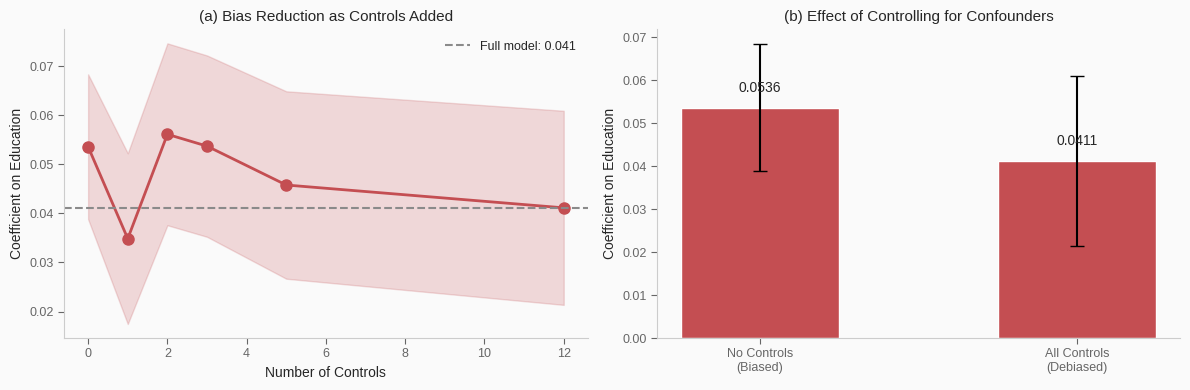

In [8]:
# Visualize bias reduction
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

# Panel 1: Coefficient trajectory
ax = axes[0]
ax.plot(results_df['n_controls'], results_df['beta_educ'], 'o-', 
        color=TUFTE_PALETTE['effect'], markersize=8, linewidth=2)
ax.fill_between(results_df['n_controls'], 
                results_df['beta_educ'] - 1.96*results_df['se'],
                results_df['beta_educ'] + 1.96*results_df['se'],
                alpha=0.2, color=TUFTE_PALETTE['effect'])
ax.axhline(model_full.params['educ'], ls='--', color=TUFTE_PALETTE['secondary'], 
           label=f'Full model: {model_full.params["educ"]:.3f}')
ax.set_xlabel('Number of Controls')
ax.set_ylabel('Coefficient on Education')
ax.set_title('(a) Bias Reduction as Controls Added')
ax.legend(frameon=False)

# Panel 2: Simple vs Full comparison
ax = axes[1]
models = ['No Controls\n(Biased)', 'All Controls\n(Debiased)']
coefs = [model_simple.params['educ'], model_full.params['educ']]
ses = [model_simple.bse['educ'], model_full.bse['educ']]
colors = [TUFTE_PALETTE['bias'], TUFTE_PALETTE['effect']]

bars = ax.bar(models, coefs, yerr=[1.96*s for s in ses], 
              color=colors, capsize=5, width=0.5, edgecolor='white')

for bar, coef in zip(bars, coefs):
    ax.text(bar.get_x() + bar.get_width()/2, coef + 0.003, 
            f'{coef:.4f}', ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Coefficient on Education')
ax.set_title('(b) Effect of Controlling for Confounders')

plt.tight_layout()
plt.show()

In [9]:
# Verify FWL connection: partialling out gives same answer
X = wage[controls].values
X_const = sm.add_constant(X)
T = wage['educ'].values
Y = wage['lhwage'].values

# Residualize
T_resid = T - X_const @ np.linalg.lstsq(X_const, T, rcond=None)[0]
Y_resid = Y - X_const @ np.linalg.lstsq(X_const, Y, rcond=None)[0]

# Bivariate on residuals
kappa_fwl = np.cov(Y_resid, T_resid)[0, 1] / np.var(T_resid, ddof=1)

print("FWL Verification")
print("="*50)
print(f"Full regression:   {model_full.params['educ']:.10f}")
print(f"FWL (partialling): {kappa_fwl:.10f}")
print(f"Match: {np.isclose(model_full.params['educ'], kappa_fwl, rtol=1e-10)}")

assert np.isclose(model_full.params['educ'], kappa_fwl, rtol=1e-10)

FWL Verification
Full regression:   0.0411471910
FWL (partialling): 0.0411471910
Match: True


---

## 4. Implementation

The `causal_inference_mastery` library provides utilities for covariate adjustment:

```python
# Outcome regression with controls
from causal_inference.observational.outcome_regression import (
    outcome_regression_ate,
    lin_estimator,  # Covariate-adjusted ATE
)

# With continuous treatment (like education)
result = outcome_regression_ate(
    outcome=wage['lhwage'],
    treatment=wage['educ'],
    covariates=wage[controls],
    robust_se=True,
)
```

For more sophisticated approaches (propensity scores, doubly robust), see Chapters 10-12.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, Economist)**: *"When does adding controls help identify causal effects? When does it hurt?"*

<details>
<summary>Solution</summary>

**When adding controls HELPS:**

1. **Confounders**: Variables that cause both treatment and outcome
   - Example: IQ affects both education and wages
   - Controlling for IQ removes this source of bias

2. **Precision**: Pre-treatment predictors of outcome reduce residual variance
   - Even if not confounders, they can improve efficiency

**When adding controls HURTS:**

1. **Colliders**: Variables caused by both treatment and outcome
   - Example: Job type is affected by both education and ability
   - Controlling for job type induces "collider bias"

2. **Mediators**: Variables on the causal path from treatment to outcome
   - Example: Occupation mediates education → wages
   - Controlling removes the indirect effect, giving only "direct" effect

3. **Post-treatment variables**: Any variable affected by treatment
   - Can introduce bias or change interpretation

**Rule**: Only control for pre-treatment confounders. Draw a DAG first!

</details>

---

**Q2 (Google L5, DS)**: *"You have observational data on a marketing campaign. What assumptions do you need to estimate the causal effect using regression?"*

<details>
<summary>Solution</summary>

**Key assumptions:**

1. **Conditional ignorability** (Selection on observables):
   - $(Y_0, Y_1) \perp T | X$
   - Treatment assignment is random *conditional on covariates*
   - Requires: all confounders observed and controlled

2. **Overlap (Positivity)**:
   - $0 < P(T=1|X) < 1$ for all $X$
   - Every covariate stratum has both treated and control units
   - Needed for extrapolation to work

3. **SUTVA (Stable Unit Treatment Value)**:
   - No interference between units
   - No hidden treatment versions

4. **Correct model specification**:
   - Linear relationships (or appropriate transformations)
   - No omitted interactions

**Practical checks:**
- Compare covariate distributions between treated/control
- Check for common support (overlap)
- Sensitivity analysis for unobserved confounders

</details>

---

**Q3 (Two Sigma, Quant)**: *"Explain the connection between FWL theorem and controlling for confounders."*

<details>
<summary>Solution</summary>

**Connection:**

FWL says: The coefficient on treatment from a multiple regression equals the coefficient from:
1. Residualize $T$ on controls $X$: get $\tilde{T} = T - E[T|X]$
2. Residualize $Y$ on controls $X$: get $\tilde{Y} = Y - E[Y|X]$
3. Regress $\tilde{Y}$ on $\tilde{T}$

**Causal interpretation:**

- $\tilde{T}$ is the part of treatment *not explained by confounders*
- If conditional ignorability holds, this residual variation is "as good as random"
- The coefficient captures the causal effect because we've removed confounding

**Why it matters:**

1. Provides intuition: "Control for X" means "use only the variation in T that X can't explain"

2. Foundation for DML: Replace linear regression with ML to estimate $E[T|X]$ and $E[Y|X]$ flexibly

3. Diagnostic: If $R^2$ from regressing $T$ on $X$ is very high, there's little residual variation → imprecise estimates

</details>

---

**Q4 (Netflix L6, DS)**: *"You're running an A/B test on a recommendation algorithm, but a colleague suggests dropping some control variables because they're correlated with treatment assignment. How do you respond?"*

<details>
<summary>Solution</summary>

**Key insight**: In a proper A/B test (RCT), treatment is randomly assigned—so there ARE no confounders by design.

**Response to colleague:**

1. **In an RCT, controls don't affect unbiasedness**:
   - Random assignment ensures $E[\hat{\kappa}] = \kappa$ regardless of controls
   - Correlation with treatment is spurious (due to finite sample)
   - Dropping controls won't introduce bias

2. **BUT controls CAN help with precision**:
   - Pre-treatment predictors of outcome reduce residual variance
   - ANCOVA/Lin estimator: include controls + treatment-control interactions
   - Can substantially reduce standard errors

3. **When to actually drop variables**:
   - Post-treatment variables (mediators, downstream outcomes)
   - Variables affected by treatment can bias results

**Recommendation**:
- Keep pre-treatment controls for efficiency
- Verify they're truly pre-treatment (measured before randomization)
- Use Lin (2013) estimator for optimal precision gains

**One-liner**: "In an RCT, controls don't fix bias (there is none), but they can buy you precision."

</details>

---

**Q5 (Citadel, Quant)**: *"Adding more controls always reduces omitted variable bias. True or false?"*

<details>
<summary>Solution</summary>

**FALSE.** This is a common misconception with important exceptions.

**When adding controls INCREASES bias:**

1. **Colliders (M-bias)**:
   ```
   A → X ← B
   A → Y
   B → T → Y
   ```
   - X is caused by both A and B
   - Controlling for X opens a backdoor path A → X ← B → T → Y
   - Introduces bias where none existed!

2. **Mediators**:
   - Control absorbs part of the treatment effect
   - Estimate becomes "direct effect only" (may not be what you want)

3. **Proxy confounders with measurement error**:
   - Imperfectly measured confounder can increase bias vs. omitting
   - "Conditioning on a noisy proxy" problem

4. **Instrumental variable contamination**:
   - If you accidentally control for an instrument, you lose identifying variation

**Correct statement**: Adding *confounders* reduces OVB. Adding *non-confounders* may increase it.

**Practical advice**:
- Draw the DAG FIRST
- Only control for variables that block backdoor paths
- Never control for descendants of treatment

**One-liner**: "Controls aren't vitamins—more isn't always better. Bad controls can poison your estimate."

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 5: "Regression For Non-Random Data."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 3.

[^3]: Imbens, G. W. (2004). Nonparametric Estimation of Average Treatment Effects Under Exogeneity: A Review. *Review of Economics and Statistics*, 86(1), 4-29.

[^4]: Rosenbaum, P. R. and Rubin, D. B. (1983). The Central Role of the Propensity Score in Observational Studies for Causal Effects. *Biometrika*, 70(1), 41-55.

---

**Precision Improvement:**
- You said: "Build the nonrandom data section"
- Concise: "Build 03_regression_nonrandom_data"
- Precise: `/facure_augment 05.3 --observational --wage-example`
- Pattern: [build] [target] [content-flags]